In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
import matplotlib.colors as clr
from matplotlib.image import cm
import os
import sys
from scipy.fftpack import dct
from scipy.fftpack import idct
import cv2
%matplotlib notebook

In [12]:
"""
Returns an array of type:
 - [x, y] for grayscale images
 - [x, y, [R, G, B]] for RGB images
 - [x, y, [R, G, B, A]] for RGBA images
"""
def read_image(filename):
    return im.imread(filename)

In [13]:
"""
Funcao para criar um colormap;
Parametros:
            1.cmin-> tuplo com valores (r,g,b) minimos
            2.cmax-> tuplo com valores (r,g,b) maximos
Devolve o objeto correspondente ao colormap
"""
def create_colormap(cmin : tuple[float], cmax: tuple[float]):
    return clr.LinearSegmentedColormap.from_list('', [cmin, cmax], N=256)

In [14]:
"""
Função para mostrar uma imagem. Aceita um colormap definido pelo utilizador ou os do matplotlib
"""
    
def show_image(img, colormap = None):    
    plt.figure(figsize=(8,8))
    
    # Imagens com apenas uma coponenete: R, G, B ou Grayscale
    if len(img.shape) == 2:
        plt.imshow(img, cmap = colormap)
    else:
        if colormap != None:
            new_img = img[:, :, 0]
            plt.imshow(new_img, cmap = colormap)
        else:
            plt.imshow(img)

    plt.axis('off')
    plt.show()

In [15]:
"""
Separar uma imagem RGB nos seus componentes
"""
def separate_components(img):
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    
    return r, g, b

In [16]:
"""
Juntar as coponentes R, G e B para formar uma imagem
"""
def join_rgb(r, g, b):
    return np.dstack((r, g, b))

In [17]:
"""
Recebe uma imagem e altera as suas dimensões (m,n) para (16*p, 16*q).
Isto é realizado através da cópia da ultima coluna/linha até atingir o valor multiplo de 16.
Conta o numero de linhas/colunas adicionadas, (x,y) : 0<=x,y<=15.
Devolve um tuplo com as dimensoes incrementadas (x,y) e a imagem com as novas dimensoes (16*p, 16*q)
"""
def padding(img : np.array):
    img = img.copy()
    shape = img.shape
    
    x,y = (16-img.shape[0]%16)%16, (16-img.shape[1]%16)%16
    h_padding = np.repeat(img[-1:,:,:], x, axis = 0)
    img = np.concatenate((img, h_padding), axis = 0)

    v_padding = np.repeat(img[:,-1:,:], y, axis = 1)
    img = np.concatenate((img, v_padding), axis = 1)
    return shape, img

"""
Recebe uma imagem e as dimensoes originais dela.
Faz slice da imagem, elimando todos os elementos incrementados no padding;
Devolve a imagem original
"""
def unpad(img : np.array, shape):
    img = img.copy()
    x,y,z = shape
    img = img[:x, :y]
    return img

In [18]:
"""
Converte imagem no formato RGB para imagem no formato yCbCr;
"""
def rgb_to_ycbcr(img : np.array):
    img.copy()
    
    y_cb_cr_mat = np.array([ [0.299    , 0.587    , 0.114    ]
                            ,[-0.168736, -0.331264, 0.5      ]
                            ,[0.5      , -0.418688, -0.081312] ])
    
    y  = y_cb_cr_mat[0,0] * img[:,:,0] + y_cb_cr_mat[0,1] * img[:,:,1] + y_cb_cr_mat[0,2]*img[:,:,2]
    cb = y_cb_cr_mat[1,0] * img[:,:,0] + y_cb_cr_mat[1,1] * img[:,:,1] + y_cb_cr_mat[1,2]*img[:,:,2] + 128
    cr = y_cb_cr_mat[2,0] * img[:,:,0] + y_cb_cr_mat[2,1] * img[:,:,1] + y_cb_cr_mat[2,2]*img[:,:,2] + 128
    
    y_cb_cr = np.dstack((y, cb, cr))
    return y_cb_cr

"""
Converte imagem no formato yCbCr para imagem no formato RGB;
"""
def ycbcr_to_rgb(img : np.array):
    img = img.copy()
    
    y_cb_cr_mat_inv = np.linalg.inv(
                                np.array([ [0.299    , 0.587    , 0.114    ]
                                        ,  [-0.168736, -0.331264, 0.5      ]
                                        ,  [0.5      , -0.418688, -0.081312] ])
                                    )
    y = img[:, :, 0]
    cb = img[:, :, 1] - 128
    cr = img[:, :, 2] - 128
    
    r = y + y_cb_cr_mat_inv[0,2]*cr
    g = y + y_cb_cr_mat_inv[1,1]*cb + y_cb_cr_mat_inv[1,2]*cr
    b = y + y_cb_cr_mat_inv[2,1]*cb
    
    rgb = np.dstack((r,g,b))
    rgb = np.round(rgb)
    rgb[rgb > 255] = 255
    rgb[rgb < 0] = 0
    
    return rgb.astype(np.uint8)

In [19]:
"""

"""
def sub_sample(y, cb, cr, downsample_ratio):
    y = y.copy()
    cb = cb.copy()
    cr = cr.copy()
    if downsample_ratio[-1] == 0:
        ratio = round(downsample_ratio[0]/downsample_ratio[1])
        cb = cb[::ratio,::ratio]
        cr = cr[::ratio,::ratio]
    else:
        v_ratio = round(downsample_ratio[0]/downsample_ratio[1])
        h_ratio = round(downsample_ratio[0]/downsample_ratio[2])
        cb = cb[:, ::v_ratio]
        cr = cr[:, ::v_ratio]
    return y,cb,cr

In [20]:
"""
funciona em -- (4,2,0) e (4,2,2) --
Parametros:
            1. y --------------> matriz com os valores da luminancia Y
            2. cb -------------> matriz downsampled de cb
            3. cr -------------> matriz downsample de cr
            4. upsample_ratio -> tuplo com 3 inteiros correspondentes ao ratio de downsample (Y:Cb:Cr)
"""
def const_up_sample(y, cb, cr, upsample_ratio):
    y = y.copy()
    cb = cb.copy()
    cr = cr.copy()
    
    cbArr = np.zeros(shape = y.shape, dtype=float)
    crArr = np.zeros(shape = y.shape, dtype=float)
    
    if upsample_ratio[-1] == 0:
        ratio = int(upsample_ratio[0]/upsample_ratio[1])
        
        cbArr[::ratio,::ratio] = cb
        cbArr[1::ratio,::ratio] = cb
        cbArr[::ratio,1::ratio] = cb
        cbArr[1::ratio,1::ratio] = cb
        
        crArr[::ratio,::ratio] = cr
        crArr[1::ratio,::ratio] = cr
        crArr[::ratio, 1::ratio] = cr
        crArr[1::ratio,1::ratio] = cr
        
    else:
        cb_ratio = int(upsample_ratio[0]/upsample_ratio[1])
        cr_ratio = int(upsample_ratio[0]/upsample_ratio[2])
        
        cbArr[:,::cb_ratio] = cb
        cbArr[:,1::cb_ratio] = cb
        
        crArr[:,::cr_ratio] = cr
        crArr[:,1::cr_ratio] = cr
        
    return y,cbArr,crArr

In [21]:
"""
funciona em -- (4,2,0) e (4,2,2) --
Parametros:
            1. y --------------> matriz com os valores da luminancia Y
            2. cb -------------> matriz downsampled de cb
            3. cr -------------> matriz downsample de cr
            4. upsample_ratio -> tuplo com 3 inteiros correspondentes ao ratio de downsample (Y:Cb:Cr)
"""
def linear_up_sample(y, cb, cr, upsample_ratio):
    y = y.copy()
    cb = cb.copy()
    cr = cr.copy()
    
    new_cb = np.zeros(shape = y.shape, dtype=float)
    new_cr = np.zeros(shape = y.shape, dtype=float)
    
    if upsample_ratio[2] == 0:
        ratio = int(upsample_ratio[0]/upsample_ratio[1])
        #--------------------Cb interpolation----
        cb_cols_mean = (cb[:,:-1] + np.roll(cb, -1, 1)[:,:-1])//2
        cb_cols_mean = np.concatenate((cb_cols_mean, cb[:,-1:]), axis = 1)

        new_cb[::2,::2] = cb
        new_cb[::2,1::2] = cb_cols_mean

        cb = new_cb[::2]
        
        cb_lines_mean = (cb[:-1] + np.roll(cb, -1, 0)[:-1])//2
        cb_lines_mean = np.concatenate((cb_lines_mean, cb[-1:]), axis = 0)

        new_cb[1::2,:] = cb_lines_mean
        
        #------------------------Cr interpolation----
        cr_cols_mean = (cr[:,:-1] + np.roll(cr, -1, 1)[:,:-1])//2
        cr_cols_mean = np.concatenate((cr_cols_mean, cr[:,-1:]), axis = 1)

        new_cr[::2,::2] = cr
        new_cr[::2,1::2] = cr_cols_mean

        cr = new_cr[::2]
        
        cr_lines_mean = (cr[:-1] + np.roll(cr, -1, 0)[:-1])//2
        cr_lines_mean = np.concatenate((cr_lines_mean, cr[-1:]), axis = 0)

        new_cr[1::2,:] = cr_lines_mean
        
    else:
        cb_ratio = int(upsample_ratio[0]/upsample_ratio[1])
        cr_ratio = int(upsample_ratio[0]/upsample_ratio[2])
        
        cb_mean = (cb[:,:-1] + np.roll(cb, -1, 1)[:,:-1])/2
        cb_mean = np.concatenate((cb_mean, cb[:,-1:]), axis = 1)
        new_cb[:,::cb_ratio] = cb
        new_cb[:,1::cb_ratio] = cb_mean
        
        cr_mean = (cr[:,:-1] + np.roll(cr, -1, 1)[:,:-1])/2
        cr_mean = np.concatenate((cr_mean, cr[:,-1:]), axis = 1)
        new_cr[:,::cr_ratio] = cr
        new_cr[:,1::cr_ratio] = cr_mean
    
    return y,new_cb, new_cr

In [22]:
def dct_(img):
    return dct(dct(img, norm="ortho").T, norm = "ortho").T

def idct_(img):
    return idct(idct(img, norm = "ortho").T, norm = "ortho").T

In [23]:
def dct_n_blocks(y, cb, cr, step):
    dct_y = np.zeros(y.shape)
    dct_cb = np.zeros(cb.shape)
    dct_cr = np.zeros(cr.shape)
    
    for i in range(0, y.shape[0], step):
        for j in range(0, y.shape[1], step):
            dct_y[i:i+step, j:j+step] = dct_(y[i:i+step, j:j+step])
    
    for i in range(0, cb.shape[0], step):
        for j in range(0, cb.shape[1], step):
            dct_cb[i:i+step, j:j+step] = dct_(cb[i:i+step, j:j+step])
            dct_cr[i:i+step, j:j+step] = dct_(cr[i:i+step, j:j+step])
            
    return dct_y, dct_cb, dct_cr

def idct_n_blocks(y, cb, cr, step):
    idct_y = np.zeros(y.shape)
    idct_cb = np.zeros(cb.shape)
    idct_cr = np.zeros(cr.shape)
    
    for i in range(0, y.shape[0], step):
        for j in range(0, y.shape[1], step):
            idct_y[ i : i+step, j:j+step] = idct_(y[i:i+step, j:j+step])
    
    for i in range(0, cb.shape[0], step):
        for j in range(0, cb.shape[1], step):
            idct_cb[ i : i+step, j : j+step] = idct_(cb[ i : i+step, j : j+step])
            idct_cr[ i : i+step, j : j+step] = idct_(cr[ i : i+step, j : j+step])
            
    return idct_y, idct_cb, idct_cr

In [24]:
def show_dct(wtv):
    show_image(np.log(np.abs(wtv) + 0.0001), create_colormap((0,0,0), (1,1,1) ) )

In [25]:
def get_Qs():
    Q_y = np.array(
        [
            [16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99],
        ]
    )
    
    Q_CbCr = np.array(
        [
            [17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
        ]
    )
    return Q_y, Q_CbCr

In [26]:
def quantitization(y, cb, cr, fator):
    q_y, q_cbcr = get_Qs()
    y_q = np.zeros(y.shape)
    cb_q = np.zeros(cb.shape)
    cr_q = np.zeros(cr.shape)
    
    if fator>=50:
        s = (100-fator)/50
    else:
        s = 50/fator
    
    if s!=0:
        q_y = np.round(s*q_y)
        q_cbcr = np.round(s*q_cbcr)
    else:
        q_y[::,::] = 1
        q_cbcr[::,::] = 1
    
    q_y[q_y>255] = 255    
    q_cbcr[q_cbcr>255] = 255
    
    for r in range(0,y.shape[0],8):
        for c in range(0,y.shape[1],8):
            y_q[r:r+8, c:c+8] = y[ r : r+8, c : c+8] / q_y
            
    for r in range(0, cb.shape[0], 8):
        for c in range(0,cb.shape[1], 8):
            cb_q[ r : r+8, c : c+8] = cb[ r : r+8, c : c+8] / q_cbcr
            cr_q[ r : r+8, c : c+8] = cr[ r : r+8, c : c+8] / q_cbcr
    
    y_q = np.round(y_q)
    cb_q = np.round(cb_q)
    cr_q = np.round(cr_q)
    return y_q, cb_q, cr_q

In [27]:
def quantitization_inverse(y, cb, cr, fator):
    q_y, q_cbcr = get_Qs()
    y_q = np.zeros(y.shape, dtype=float)
    cb_q = np.zeros(cb.shape, dtype= float)
    cr_q = np.zeros(cr.shape, dtype=float)
    
    if fator>=50:
        s = (100-fator)/50
    else:
        s = 50/fator
    
    if s!=0:
        q_y = np.round(s*q_y)
        q_cbcr = np.round(s*q_cbcr)
    else:
        q_y[::,::] = 1
        q_cbcr[::,::] = 1
    
    q_y[ q_y > 255 ] = 255    
    q_cbcr[ q_cbcr > 255 ] = 255
    
    for r in range(0, y.shape[0], 8):
        for c in range(0, y.shape[1], 8):
            y_q[ r : r+8, c : c+8] = y[ r : r+8, c : c+8]*q_y
            
    for r in range(0, cb.shape[0], 8):
        for c in range(0, cb.shape[1], 8):
            cb_q[ r : r+8, c : c+8] = cb[ r : r+8, c : c+8] * q_cbcr
            cr_q[ r : r+8, c : c+8] = cr[ r : r+8, c : c+8] * q_cbcr
    
    y_q = np.round(y_q)
    cb_q = np.round(cb_q)
    cr_q = np.round(cr_q)
    return y_q, cb_q, cr_q

In [28]:
def diff(bloco):
    x, y = bloco.shape
    bloco = bloco.flatten().astype(float)
    bloco[1:] -= bloco[:-1]
    return bloco.reshape(x,y)

def DPCM(y,cb,cr):

    yBlocks = y.copy()
    cbBlocks = cb.copy()
    crBlocks = cr.copy()
    
    yBlocks[::8,::8] = diff(y[::8,::8])
    cbBlocks[::8,::8] = diff(cb[::8,::8])
    crBlocks[::8,::8] = diff(cr[::8,::8])
        
    return yBlocks, cbBlocks, crBlocks

In [29]:
def diff_reverse(bloco):
    x, y = bloco.shape
    bloco = bloco.flatten().astype(float)
    for i in range(1,bloco.shape[0]):
        bloco[i] = bloco[i] + bloco[i-1]
    return bloco.reshape(x,y)

def DPCM_reverse(yBlocks, cbBlocks, crBlocks):
    y = yBlocks.copy()
    cr = crBlocks.copy()
    cb = cbBlocks.copy()
    
    y[::8,::8] = diff_reverse(yBlocks[::8,::8])
    cr[::8,::8] = diff_reverse(crBlocks[::8,::8])
    cb[::8,::8] = diff_reverse(cbBlocks[::8,::8])
    
    return y, cb, cr

In [30]:
def MSE(orig, compressed):
    return np.sum( np.square( orig-compressed ) ) / np.prod(orig.shape) * 3

In [31]:
def RMSE(orig, compressed):
    return np.sqrt(MSE(orig,compressed))

In [32]:
def SNR(orig, compressed):
    P = np.sum(np.square(orig))/np.prod(orig.shape)
    return 10*np.log10(P/MSE(orig, compressed))

In [33]:
def PSNR(orig, compressed):
    return 10*np.log10(np.square(orig).max()/MSE(orig,compressed))

In [34]:
def read_image(filename):
    img = im.imread(filename)
    return img

In [35]:
gray = create_colormap((0,0,0), (1,1,1))

In [36]:
def encoder(img, ratio, block_size, fator, debug=False):
    shape, img = padding(img)
    y_cb_cr = rgb_to_ycbcr(img) 
    y,cb,cr = separate_components(y_cb_cr)
    y,cb,cr = sub_sample(y,cb,cr, ratio)
    y,cb,cr = dct_n_blocks(y, cb, cr, block_size)
    y,cb,cr = quantitization(y,cb,cr,fator)
    print(cb[8:16,8:16])
    y,cb,cr = DPCM(y,cb,cr)
    return y,cb,cr, shape

In [37]:
def decoder(y, cb, cr, shape, ratio, block_size,fator, debug=False):
    y,cb,cr = DPCM_reverse(y,cb,cr)
    y,cb,cr = quantitization_inverse(y, cb, cr, fator)
    y, cb, cr = idct_n_blocks(y, cb, cr, block_size)
    y, cb, cr = linear_up_sample(y, cb, cr, ratio)
    #y, cb, cr = const_up_sample(y,cb,cr, ratio)
    img = join_rgb(y, cb, cr)
    img = ycbcr_to_rgb(img)
    img = unpad(img, shape)
    return img

In [38]:
orig = im.imread("imagens/barn_mountains.bmp")
ratio = (4,2,0)
block = 8
fator = 75
y,cb,cr,shape = encoder(orig, ratio, block,fator, debug=0)
dec = decoder(y,cb,cr, shape, ratio, block,fator, debug=0)

MSE(orig.astype(float), dec.astype(float))

[[169.   0.   0.   0.  -0.  -0.  -0.  -0.]
 [  0.  -0.  -0.   0.  -0.   0.   0.  -0.]
 [  0.  -0.  -0.  -0.  -0.   0.   0.  -0.]
 [ -0.   0.   0.   0.  -0.   0.  -0.  -0.]
 [ -0.  -0.   0.  -0.   0.   0.   0.  -0.]
 [  0.  -0.  -0.  -0.   0.   0.   0.  -0.]
 [ -0.  -0.  -0.   0.   0.  -0.  -0.  -0.]
 [ -0.  -0.  -0.   0.   0.  -0.  -0.   0.]]


171.93462962962963

<IPython.core.display.Javascript object>


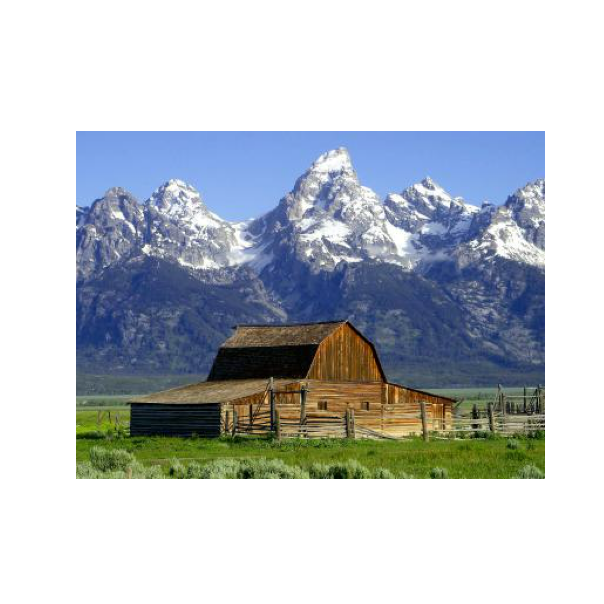

In [39]:
show_image(dec)